In [1]:
%matplotlib inline

# %matplotlib widget

# Generate Data 

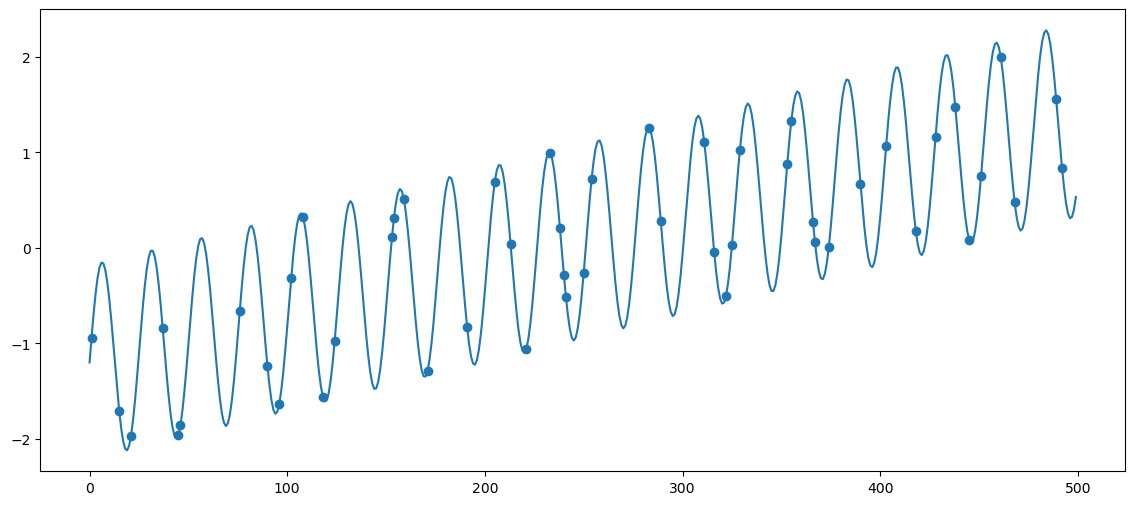

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

def f(x):
    eps = 0.3
    return x + AMP * np.sin(SCALE * x) # + eps*np.random.randn(1)


def sample_sin(seed=0):
    np.random.seed(seed)
    
    X = np.arange(MAX_N)
    Y = f(X)
    
    some_X = np.random.choice(X, N, replace=False)
    some_Y = Y[some_X]
    return X.reshape(-1, 1), Y.reshape(-1, 1), some_X.reshape(-1, 1), some_Y.reshape(-1, 1)


MAX_N = 500
N = 50
SCALE = 1/4
AMP = 200

X, Y, some_X, some_Y = sample_sin()

scaler = preprocessing.StandardScaler().fit(some_Y)
Y, some_Y = map(scaler.transform, [Y, some_Y])

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(X, Y)
ax.scatter(some_X, some_Y)
plt.show()

# GP

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

X_train, y_train = some_X, some_Y
y = Y

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

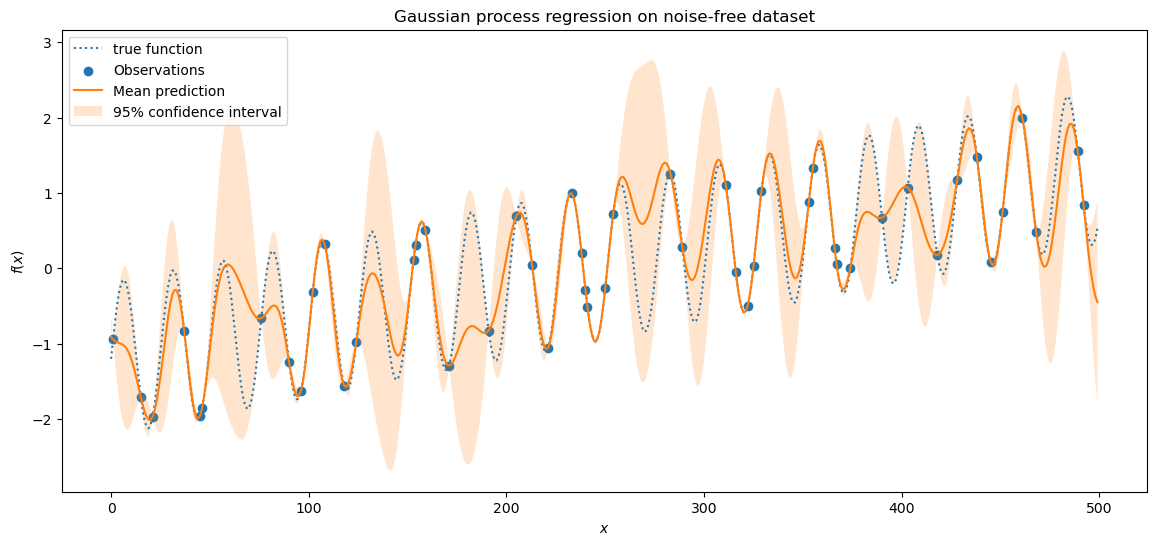

In [4]:
# plot GP

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(X, y, label=r"true function", linestyle="dotted")
ax.scatter(X_train, y_train, label="Observations")
ax.plot(X, mean_prediction, label="Mean prediction")
ax.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.2,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian process regression on noise-free dataset")
plt.show()

# Kernel Ridge Regression

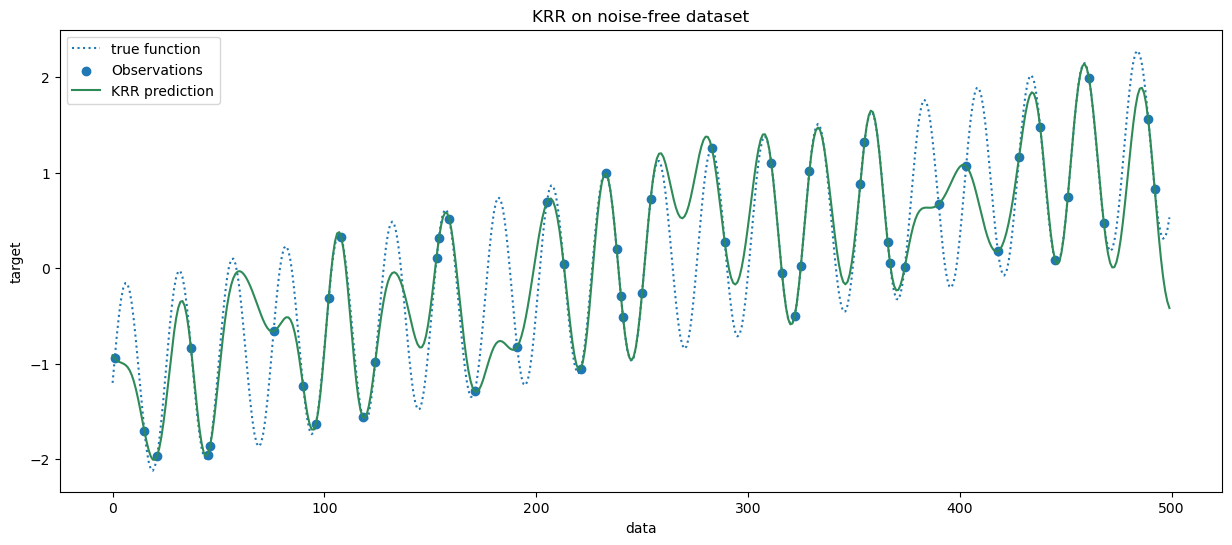

In [5]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

# kr = KernelRidge(kernel="rbf", gamma=0.1)
kr.fit(X_train, y_train)
kr_pred = kr.predict(X)

# plot KRR

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(X, y, label=r"true function", linestyle="dotted")
ax.scatter(X_train, y_train, label="Observations")
ax.plot(X, kr_pred, label="KRR prediction", color='seagreen')
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
plt.title("KRR on noise-free dataset")
plt.show()

# GP vs. KRR

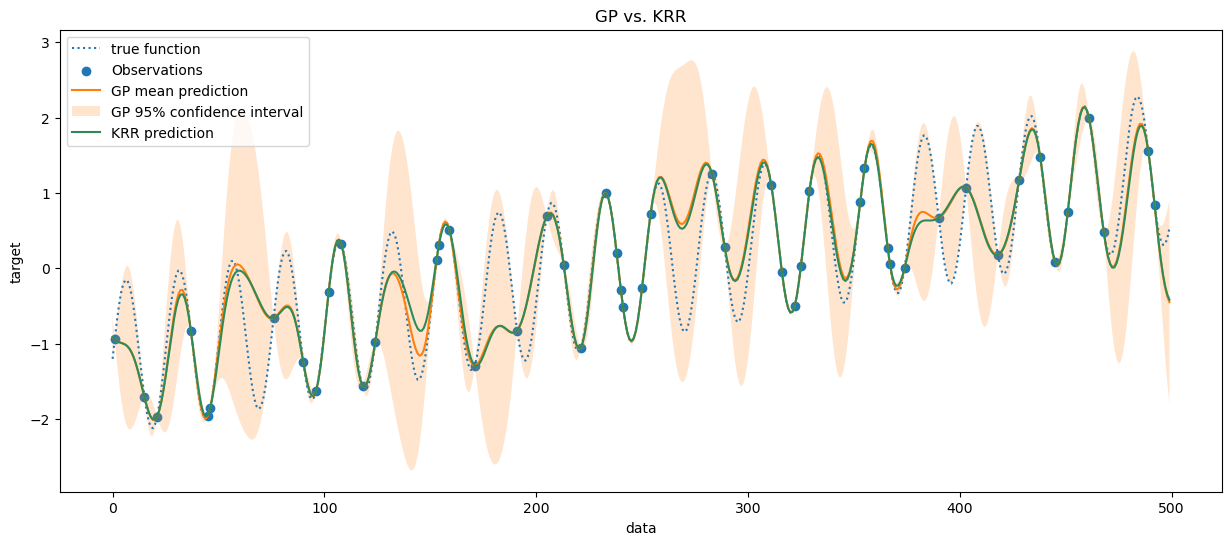

In [6]:
# plot both

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(X, y, label=r"true function", linestyle="dotted")
ax.scatter(X_train, y_train, label="Observations")

# GP
ax.plot(X, mean_prediction, label="GP mean prediction")
ax.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.2,
    label=r"GP 95% confidence interval",
)

# KRR
ax.plot(X, kr_pred, label="KRR prediction", color='seagreen')

ax.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("GP vs. KRR")

# GP vs. QR

In [7]:
# source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html


from sklearn.linear_model import QuantileRegressor

quantiles = [quant_min, quant_median, quant_max] = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y.ravel(), dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X_train, y_train.ravel()).predict(X)
    predictions[quantile] = y_pred
"""
    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )
"""

'\n    if quantile == min(quantiles):\n        out_bounds_predictions = np.logical_or(\n            out_bounds_predictions, y_pred >= y_normal\n        )\n    elif quantile == max(quantiles):\n        out_bounds_predictions = np.logical_or(\n            out_bounds_predictions, y_pred <= y_normal\n        )\n'

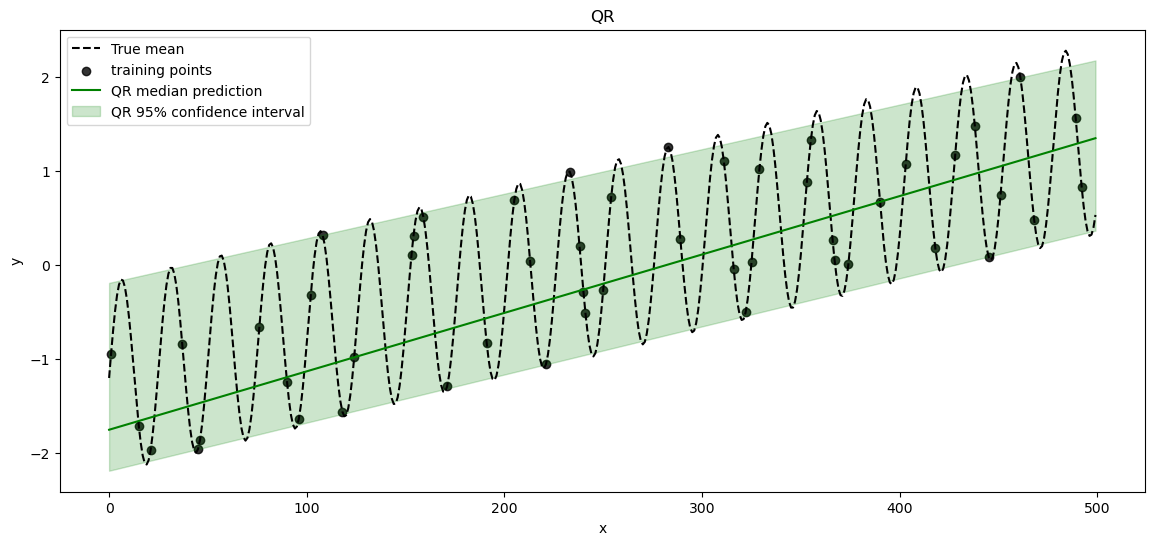

In [8]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(X, y, color="black", linestyle="dashed", label="True mean")

#for quantile, y_pred in predictions.items():
    #ax.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    X_train,
    y_train,
    color="black",
    marker="o",
    alpha=0.8,
    label="training points",
)

ax.plot(X, predictions[quant_median], label="QR median prediction", color='green')
ax.fill_between(
    X.ravel(),
    predictions[quant_min],
    predictions[quant_max],
    color='green',
    alpha=0.2,
    label=r"QR 95% confidence interval",
)


plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("QR")
plt.show()

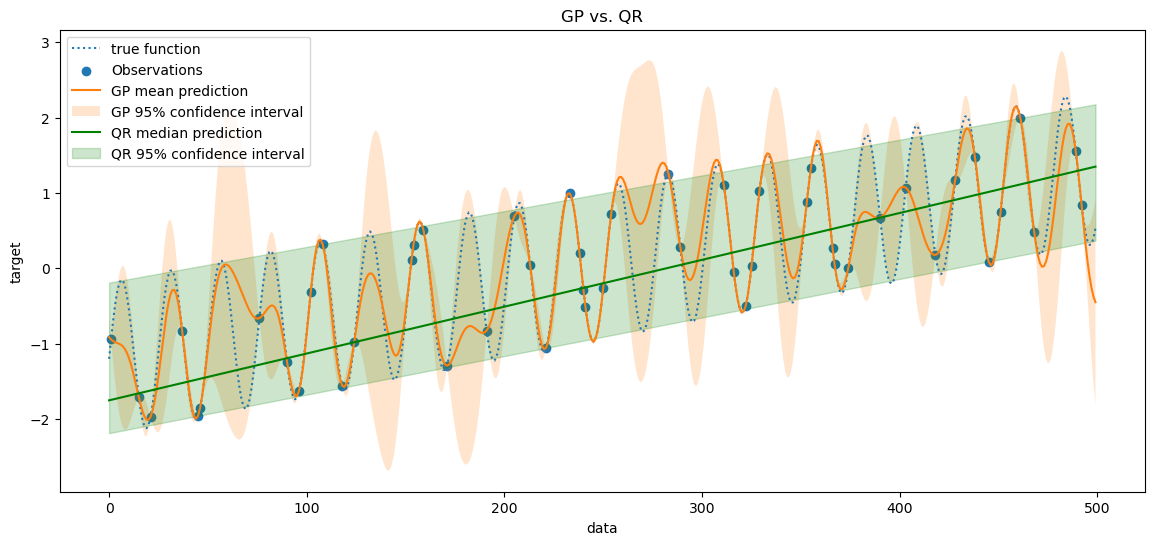

In [9]:
# plot both

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(X, y, label=r"true function", linestyle="dotted")
ax.scatter(X_train, y_train, label="Observations")

# GP
ax.plot(X, mean_prediction, label="GP mean prediction")
ax.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.2,
    label=r"GP 95% confidence interval",
)

# QR
ax.plot(X, predictions[quant_median], label="QR median prediction", color='green')
ax.fill_between(
    X.ravel(),
    predictions[quant_min],
    predictions[quant_max],
    color='green',
    alpha=0.2,
    label=r"QR 95% confidence interval",
)

ax.legend()
plt.xlabel("data")
plt.ylabel("target")
plt.title("GP vs. QR")
plt.show()